In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import solve_bvp # import the TPBVP solver

In [2]:
# Problem 2

def f(x):
    """given function"""
    return (0.26 * ((x[0]**2) + (x[1]**2))) - (0.46 * (x[0] * x[1]))

    
def f_grad(x):
    """calculates the gradient of the f function above"""
    dJdx1 = (0.52 * x[0]) - (0.46 * x[1])
    dJdx2 = (0.52 * x[1]) - (0.46 * x[0])

    return np.array([dJdx1, dJdx2])


def armijo(x, gamma_0, alpha, beta):
    """armijo line search"""
    gamma = gamma_0
    z = -1*f_grad(x)

    while f(x + (gamma*z)) > (f(x) + (alpha * gamma * np.dot(f_grad(x).T, z))):
        gamma *= beta

    x += gamma * z

    return x


def compute_z(X, Y):
    """Compute function values Z"""
    Z = np.zeros_like(X)  # Initialize array for function values
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = f([X[i, j], Y[i, j]])
    return Z

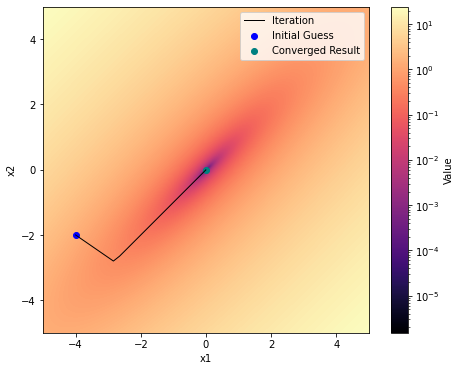

In [8]:
# Establish all variables
x_range = np.linspace(-5, 5, 1000)
y_range = np.linspace(-5, 5, 1000)

X, Y  = np.meshgrid(x_range, y_range)
x_input = [X, Y]
z_mat = compute_z(X, Y)

n_iter = 100
gamma_init = 1.0
alpha = 10e-4
beta = 0.5
init_guess = np.array([-4.0, -2.0])

x_traj = np.zeros(shape=(n_iter + 1, 2))
x_traj[0, :] = init_guess

# Run through all iterations
for i in range(n_iter):
    x_traj[i+1, :] = armijo(init_guess, gamma_init, alpha, beta)

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(z_mat, origin="lower", extent=[-5, 5, -5, 5], cmap="magma", norm=mcolors.LogNorm())
plt.colorbar(label='Value')
plt.plot(x_traj[:, 0], x_traj[:, 1], color="black", linewidth=1, label="Iteration")
plt.scatter(x_traj[0, 0], x_traj[0, 1], color="b", label="Initial Guess")
plt.scatter(x_traj[n_iter, 0], x_traj[n_iter, 1], color="teal", label="Converged Result")
plt.legend(loc='upper right')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

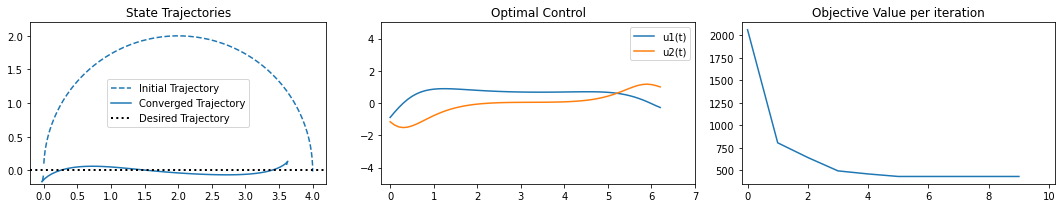

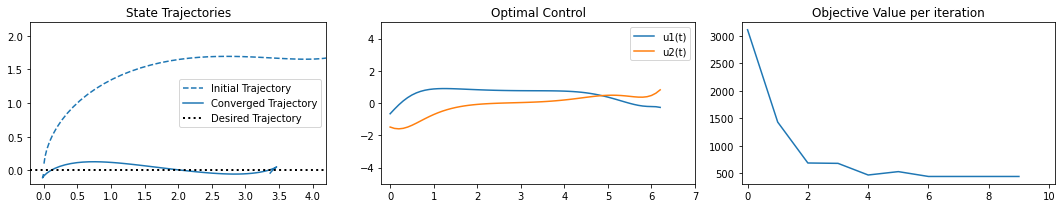

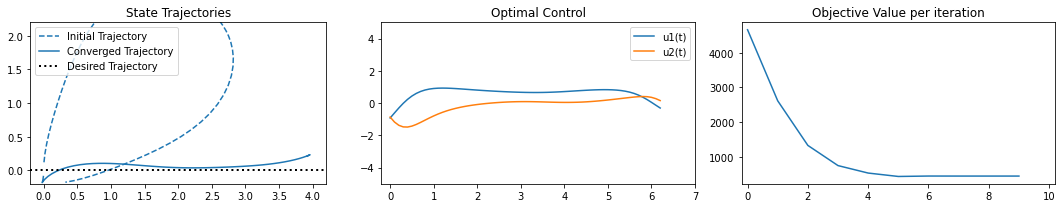

In [17]:
### define parameters

dt = 0.1
x0 = np.array([0.0, 0.0, np.pi/2.0])
# tsteps = 63
T = 2.0 * np.pi
tlist = np.arange(0, T, dt)
tsteps = tlist.shape[0]
init_u_traj = np.tile(np.array([1.0, -0.5]), reps=(tsteps,1))

Q_x = np.diag([10.0, 10.0, 2.0])
R_u = np.diag([4.0, 2.0])
P1 = np.diag([20.0, 20.0, 5.0])

Q_z = np.diag([5.0, 5.0, 1.0])
R_v = np.diag([2.0, 1.0])

def dyn(xt, ut):
    # xdot = np.zeros(3)  # replace this
    theta = xt[2]
    u1 = ut[0]
    u2 = ut[1]
    x1dot = np.cos(theta) * u1
    x2dot = np.sin(theta) * u1
    x3dot = u2

    xdot = np.array([x1dot, x2dot, x3dot])
    return xdot


def get_A(t, xt, ut):
    A = np.zeros((3,3))  # replace this
    theta = xt[2]
    u1 = ut[0]
    A[0, 2] = -np.sin(theta) * u1
    A[1, 2] = np.cos(theta) * u1
    return A


def get_B(t, xt, ut):
    B = np.zeros((3,2))  # replace this
    theta = xt[2]
    B[0, 0] = np.cos(theta)
    B[1, 0] = np.sin(theta)
    B[2, 1] = 1
    return B


def step(xt, ut):
    # xt_new = xt + dt * dyn(xt, ut)  # recommended: replace it with RK4 integration
    k1 = dt * dyn(xt, ut)
    k2 = dt * dyn(xt + k1 / 2.0, ut)
    k3 = dt * dyn(xt + k2 / 2.0, ut)
    k4 = dt * dyn(xt + k3, ut)

    xt_new = xt + 1.0 / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
    return xt_new


def traj_sim(x0, ulist):
    tsteps = ulist.shape[0]
    x_traj = np.zeros((tsteps, 3))
    xt = x0.copy()
    for t in range(tsteps):
        xt_new = step(xt, ulist[t])
        x_traj[t] = xt_new.copy()
        xt = xt_new.copy()
    return x_traj


def loss(t, xt, ut):
    xd = np.array([2.0*t / np.pi, 0.0, np.pi/2.0])  # desired system state at time t

    x_diff = xt - xd
    x_loss = x_diff.T @ Q_x @ x_diff
    u_loss = ut.T @ R_u @ ut

    return x_loss + u_loss


def dldx(t, xt, ut):
    xd = np.array([2.0*t / np.pi, 0.0, np.pi/2.0])

    qlist = np.diag(Q_x)

    # dvec = np.zeros(3)  # replace this
    dx = xt - xd
    dvec = 2 * qlist * dx
    return dvec


def dldu(t, xt, ut):
    # dvec = np.zeros(2)  # replace this
    rlist = np.diag(R_u)
    dvec = 2 * rlist * ut
    return dvec

def J_xu(x_traj, u_traj):
        J_val = 0

        for xt, ut, t in zip(x_traj[:, :], u_traj, tlist):
            l_val = loss(t, xt, ut)
            J_val += l_val

        xd_T = np.array([2.0 * tlist[-1] / np.pi, 0.0, np.pi / 2.0])
        xT = x_traj[-1]
        dx_T = xT - xd_T

        J_val += dx_T.T @ P1 @ dx_T

        return J_val

def ilqr_iter(x0, u_traj):
    """
    :param x0: initial state of the system
    :param u_traj: current estimation of the optimal control trajectory
    :return: the descent direction for the control
    """
    # forward simulate the state trajectory
    x_traj = traj_sim(x0, u_traj)

    # compute other variables needed for specifying the dynamics of z(t) and p(t)
    A_list = np.zeros((tsteps, 3, 3))
    B_list = np.zeros((tsteps, 3, 2))
    a_list = np.zeros((tsteps, 3))
    b_list = np.zeros((tsteps, 2))
    for t_idx in range(tsteps):
        t = t_idx * dt
        A_list[t_idx] = get_A(t, x_traj[t_idx], u_traj[t_idx])
        B_list[t_idx] = get_B(t, x_traj[t_idx], u_traj[t_idx])
        a_list[t_idx] = dldx(t, x_traj[t_idx], u_traj[t_idx])
        b_list[t_idx] = dldu(t, x_traj[t_idx], u_traj[t_idx])

    xd_T = np.array([2.0*(tsteps-1)*dt / np.pi, 0.0, np.pi/2.0])  # desired terminal state
    p1 = 2 * np.diag(P1) * (x_traj[-1,:] - xd_T)

    def zp_dyn(t, zp):
        zt = zp[:3]
        pt = zp[3:]
        t_idx = (t/dt).astype(int)
        At = A_list[t_idx]
        Bt = B_list[t_idx]
        at = a_list[t_idx]
        bt = b_list[t_idx]

        M_11 = At
        M_12 = np.zeros((3,3))  # DONT replace this
        M_21 = np.zeros((3,3))  # DONT replace this
        M_22 = -1*At.T
        dyn_mat = np.block([
            [M_11, M_12],
            [M_21, M_22]
        ])

        m_1 = -Bt @ np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        m_2 = -at - zt @ Q_z
        dyn_vec = np.hstack([m_1, m_2])

        return dyn_mat @ zp + dyn_vec

    # this will be the actual dynamics function you provide to solve_bvp,
    # it takes in a list of time steps and corresponding [z(t), p(t)]
    # and returns a list of [zdot(t), pdot(t)]
    def zp_dyn_list(t_list, zp_list):
        list_len = len(t_list)
        zp_dot_list = np.zeros((6, list_len))
        for _i in range(list_len):
            zp_dot_list[:,_i] = zp_dyn(t_list[_i], zp_list[:,_i])
        return zp_dot_list

    # boundary condition (inputs are [z(0),p(0)] and [z(T),p(T)])
    def zp_bc(zp_0, zp_T):
        # return np.zeros(6)  # replace this
        z0 = zp_0[:3]
        p0 = zp_0[3:]

        zT = zp_T[:3]
        pT = zp_T[3:]

        bc = np.zeros(6)
        bc[:3] = z0
        bc[3:] = np.abs(pT - p1)
        # print(bc)

        return bc

    ### The solver will say it does not converge, but the returned result
    ### is numerically accurate enough for our use
    # zp_traj = np.zeros((tsteps,6))  # replace this by using solve_bvp
    tlist = np.arange(tsteps) * dt
    res = solve_bvp(
        zp_dyn_list, zp_bc, tlist, np.zeros((6,tsteps)),
        max_nodes=100
    )
    zp_traj = res.sol(tlist).T

    z_traj = zp_traj[:,:3]
    p_traj = zp_traj[:,3:]

    v_traj = np.zeros((tsteps, 2))
    for _i in range(tsteps):
        At = A_list[_i]
        Bt = B_list[_i]
        at = a_list[_i]
        bt = b_list[_i]

        zt = z_traj[_i]
        pt = p_traj[_i]

        # vt = np.zeros(2)  # replace this
        vt = -1*np.linalg.inv(R_v.T) @ (pt.T @ Bt + bt.T)
        v_traj[_i] = vt

    return v_traj

# Start iLQR iterations here

u_traj = init_u_traj.copy()
j_array = np.zeros((10, 2))
x_traj_init = traj_sim(x0, u_traj)
for iter in range(10):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)

    # # visualize the current trajectory
    # fig, ax = plt.subplots(1, 1)
    # ax.set_title('Iter: {:d}'.format(iter))
    # ax.set_aspect('equal')
    # ax.set_xlim(-0.2, 4.2)
    # ax.set_ylim(-0.2, 2.2)
    # ax.plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C0')
    # plt.show()
    # plt.close()

    # get descent direction
    v_traj = ilqr_iter(x0, u_traj)

    # Armijo line search parameters
    gamma = 1.0  # initial step size
    alpha = 1e-04
    beta = 0.5

    ### Implement Armijo line search here to update step size gamma
    while J_xu(x_traj, u_traj + gamma * v_traj) > J_xu(x_traj, u_traj) + alpha * gamma * np.abs(np.trace(-v_traj.T @ v_traj)):
        gamma *= beta

    j_array[iter, 0] = iter
    j_array[iter, 1] = J_xu(x_traj, u_traj + gamma * v_traj)
    # update control for the next iteration
    u_traj += gamma * v_traj


# visualize the current trajectory
fig1, ax1 = plt.subplots(1, 3, figsize=(15, 3))

ax1[0].set_title('State Trajectories')
ax1[0].set_aspect('equal')
ax1[0].set_xlim(-0.2, 4.2)
ax1[0].set_ylim(-0.2, 2.2)
ax1[0].plot(x_traj_init[:,0], x_traj_init[:,1], linestyle='--', color='C0', label='Initial Trajectory')
ax1[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C0', label='Converged Trajectory')
ax1[0].axhline(0, color='k', linestyle=':', linewidth=2, label='Desired Trajectory') 
ax1[0].legend()

ax1[1].set_title('Optimal Control')
ax1[1].set_aspect('auto')
ax1[1].set_xlim(-0.2, 7.0)
ax1[1].set_ylim(-5.0, 5.0)
ax1[1].plot(tlist, u_traj[:,0], linestyle='-', label='u1(t)')
ax1[1].plot(tlist, u_traj[:,1], linestyle='-', label='u2(t)')
ax1[1].legend()

ax1[2].set_title('Objective Value per iteration')
ax1[2].set_aspect('auto')
ax1[2].set_xlim(-0.2, 10.2)
ax1[2].plot(j_array[:,0], j_array[:,1], linestyle='-', color='C0', label='Final')
plt.tight_layout()
plt.show()

########## Second Round ##########
init_u_traj = np.zeros((tsteps, 2))
for q in range(tsteps):
    init_u_traj[q, 0] = 1.0 + 0.5 * np.sin(2 * np.pi * q / tsteps)  # sinusoidal u1
    init_u_traj[q, 1] = -1.0 + 2.0 * (q / tsteps)                   # ramp u2

u_traj = init_u_traj.copy()
j_array = np.zeros((10, 2))
x_traj_init = traj_sim(x0, u_traj)
for iter in range(10):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)

    # get descent direction
    v_traj = ilqr_iter(x0, u_traj)

    # Armijo line search parameters
    gamma = 1.0  # initial step size
    alpha = 1e-04
    beta = 0.5

    ### Implement Armijo line search here to update step size gamma
    while J_xu(x_traj, u_traj + gamma * v_traj) > J_xu(x_traj, u_traj) + alpha * gamma * np.abs(np.trace(-v_traj.T @ v_traj)):
        gamma *= beta

    j_array[iter, 0] = iter
    j_array[iter, 1] = J_xu(x_traj, u_traj + gamma * v_traj)
    # update control for the next iteration
    u_traj += gamma * v_traj


fig2, ax2 = plt.subplots(1, 3, figsize=(15, 3))

ax2[0].set_title('State Trajectories')
ax2[0].set_aspect('equal')
ax2[0].set_xlim(-0.2, 4.2)
ax2[0].set_ylim(-0.2, 2.2)
ax2[0].plot(x_traj_init[:,0], x_traj_init[:,1], linestyle='--', color='C0', label='Initial Trajectory')
ax2[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C0', label='Converged Trajectory')
ax2[0].axhline(0, color='k', linestyle=':', linewidth=2, label='Desired Trajectory') 
ax2[0].legend()

ax2[1].set_title('Optimal Control')
ax2[1].set_aspect('auto')
ax2[1].set_xlim(-0.2, 7.0)
ax2[1].set_ylim(-5.0, 5.0)
ax2[1].plot(tlist, u_traj[:,0], linestyle='-', label='u1(t)')
ax2[1].plot(tlist, u_traj[:,1], linestyle='-', label='u2(t)')
ax2[1].legend()

ax2[2].set_title('Objective Value per iteration')
ax2[2].set_aspect('auto')
ax2[2].set_xlim(-0.2, 10.2)
ax2[2].plot(j_array[:,0], j_array[:,1], linestyle='-', color='C0', label='Final')
plt.tight_layout()
plt.show()

########## Third Round ##########
init_u_traj = np.zeros((tsteps, 2))
for q in range(tsteps):
    init_u_traj[q, 0] = 1.2 + 0.7 * np.sin(3 * np.pi * q / tsteps)   # smoother, larger sine for u1
    init_u_traj[q, 1] = -0.8 + 0.6 * np.sin(5 * np.pi * q / tsteps)  # different sine for u2

u_traj = init_u_traj.copy()
j_array = np.zeros((10, 2))
x_traj_init = traj_sim(x0, u_traj)
for iter in range(10):
    # forward simulate the current trajectory
    x_traj = traj_sim(x0, u_traj)

    # get descent direction
    v_traj = ilqr_iter(x0, u_traj)

    # Armijo line search parameters
    gamma = 1.0  # initial step size
    alpha = 1e-04
    beta = 0.5

    ### Implement Armijo line search here to update step size gamma
    while J_xu(x_traj, u_traj + gamma * v_traj) > J_xu(x_traj, u_traj) + alpha * gamma * np.abs(np.trace(-v_traj.T @ v_traj)):
        gamma *= beta

    j_array[iter, 0] = iter
    j_array[iter, 1] = J_xu(x_traj, u_traj + gamma * v_traj)
    # update control for the next iteration
    u_traj += gamma * v_traj


fig3, ax3 = plt.subplots(1, 3, figsize=(15, 3))

ax3[0].set_title('State Trajectories')
ax3[0].set_aspect('equal')
ax3[0].set_xlim(-0.2, 4.2)
ax3[0].set_ylim(-0.2, 2.2)
ax3[0].plot(x_traj_init[:,0], x_traj_init[:,1], linestyle='--', color='C0', label='Initial Trajectory')
ax3[0].plot(x_traj[:,0], x_traj[:,1], linestyle='-', color='C0', label='Converged Trajectory')
ax3[0].axhline(0, color='k', linestyle=':', linewidth=2, label='Desired Trajectory') 
ax3[0].legend()

ax3[1].set_title('Optimal Control')
ax3[1].set_aspect('auto')
ax3[1].set_xlim(-0.2, 7.0)
ax3[1].set_ylim(-5.0, 5.0)
ax3[1].plot(tlist, u_traj[:,0], linestyle='-', label='u1(t)')
ax3[1].plot(tlist, u_traj[:,1], linestyle='-', label='u2(t)')
ax3[1].legend()

ax3[2].set_title('Objective Value per iteration')
ax3[2].set_aspect('auto')
ax3[2].set_xlim(-0.2, 10.2)
ax3[2].plot(j_array[:,0], j_array[:,1], linestyle='-', color='C0', label='Final')
plt.tight_layout()
plt.show()